<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/DatasciencePresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
epoch = 40

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


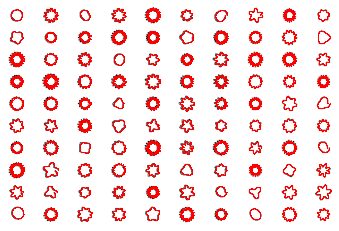

In [2]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        radii[i,:] += a
    
    assert torch.min(radii)>0
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            #sample = torch.stack([sample for i in range(64)],dim = 0).cuda()
            pred = model(sample.cuda())#come back to this
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            assert X.shape[0] == 1000
            assert Y.shape[0] == 1000
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            plt.plot(X.cpu(),Y.cpu(),',-',c='red', ms=.1, lw=0.1) 

    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class DonutDataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        #z = torch.zeros(numpoints,1)
        #points = torch.cat([points,z], dim = 1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)
        
test_dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',test_dataset, model = None)


In [3]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
#test_dataset = DonutDataset(length=100)
loader_test = data.DataLoader(
    test_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=test_dataset),
    num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length=64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [6]:
model = MLP().cuda()

In [7]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))

In [8]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 16.97130584716797
epoch 1 	Training loss 6.187532424926758
epoch 2 	Training loss 4.350442409515381
epoch 3 	Training loss 3.952571153640747
epoch 4 	Training loss 2.8805267810821533
epoch 5 	Training loss 2.4231271743774414
epoch 6 	Training loss 2.176990270614624
epoch 7 	Training loss 2.008396625518799
epoch 8 	Training loss 2.0223591327667236
epoch 9 	Training loss 1.9413211345672607
epoch 10 	Training loss 1.9778622388839722
epoch 11 	Training loss 1.8264240026474
epoch 12 	Training loss 1.9429177045822144
epoch 13 	Training loss 1.7538079023361206
epoch 14 	Training loss 1.7364652156829834
epoch 15 	Training loss 1.7567752599716187
epoch 16 	Training loss 1.6326889991760254
epoch 17 	Training loss 1.7044727802276611
epoch 18 	Training loss 1.6023210287094116
epoch 19 	Training loss 1.4354366064071655
epoch 20 	Training loss 1.609421730041504
epoch 21 	Training loss 1.5105129480361938
epoch 22 	Training loss 1.6205134391784668
epoch 23 	Training loss 1.63597

In [9]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))

In [10]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 1.311394214630127
epoch 1 	Training loss 1.387424349784851
epoch 2 	Training loss 1.3556562662124634
epoch 3 	Training loss 1.2279539108276367
epoch 4 	Training loss 1.4462673664093018
epoch 5 	Training loss 1.4090107679367065
epoch 6 	Training loss 1.398068904876709
epoch 7 	Training loss 1.2652732133865356
epoch 8 	Training loss 1.3874660730361938
epoch 9 	Training loss 1.3665767908096313
epoch 10 	Training loss 1.3089014291763306
epoch 11 	Training loss 1.3238825798034668
epoch 12 	Training loss 1.2575629949569702
epoch 13 	Training loss 1.3991276025772095
epoch 14 	Training loss 1.241169810295105
epoch 15 	Training loss 1.3137880563735962
epoch 16 	Training loss 1.2109479904174805
epoch 17 	Training loss 1.2838084697723389
epoch 18 	Training loss 1.3562308549880981
epoch 19 	Training loss 1.2706540822982788
epoch 20 	Training loss 1.3645156621932983
epoch 21 	Training loss 1.2159974575042725
epoch 22 	Training loss 1.2148473262786865
epoch 23 	Training loss 1

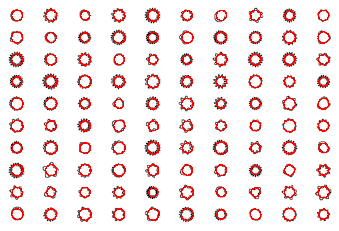

In [11]:
model = model.eval()
DonutDataset.displayCanvas('test3layerConstantWidth.png',test_dataset, model = model)


In [12]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [13]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [14]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 15.23814582824707
epoch 1 	Training loss 5.763535499572754
epoch 2 	Training loss 4.3202362060546875
epoch 3 	Training loss 2.6375815868377686
epoch 4 	Training loss 2.4650607109069824
epoch 5 	Training loss 2.259899139404297
epoch 6 	Training loss 2.239328622817993
epoch 7 	Training loss 2.0221800804138184
epoch 8 	Training loss 1.9108633995056152
epoch 9 	Training loss 1.9943360090255737
epoch 10 	Training loss 1.7713032960891724
epoch 11 	Training loss 1.8656038045883179
epoch 12 	Training loss 1.713749647140503
epoch 13 	Training loss 1.6306524276733398
epoch 14 	Training loss 1.6117380857467651
epoch 15 	Training loss 1.622527003288269
epoch 16 	Training loss 1.5947626829147339
epoch 17 	Training loss 1.7273261547088623
epoch 18 	Training loss 1.5569459199905396
epoch 19 	Training loss 1.5962177515029907
epoch 20 	Training loss 1.528193712234497
epoch 21 	Training loss 1.345949649810791
epoch 22 	Training loss 1.5318500995635986
epoch 23 	Training loss 1.544

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))

In [16]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 1.3297274112701416
epoch 1 	Training loss 1.3424443006515503
epoch 2 	Training loss 1.3275456428527832
epoch 3 	Training loss 1.3027856349945068
epoch 4 	Training loss 1.4547903537750244
epoch 5 	Training loss 1.4090934991836548
epoch 6 	Training loss 1.3456639051437378
epoch 7 	Training loss 1.338087558746338
epoch 8 	Training loss 1.3188612461090088
epoch 9 	Training loss 1.2876043319702148
epoch 10 	Training loss 1.2731136083602905
epoch 11 	Training loss 1.2571146488189697
epoch 12 	Training loss 1.4190771579742432
epoch 13 	Training loss 1.2878843545913696
epoch 14 	Training loss 1.382753610610962
epoch 15 	Training loss 1.2230085134506226
epoch 16 	Training loss 1.313958764076233
epoch 17 	Training loss 1.2690231800079346
epoch 18 	Training loss 1.3289130926132202
epoch 19 	Training loss 1.2810471057891846
epoch 20 	Training loss 1.356937050819397
epoch 21 	Training loss 1.3029885292053223
epoch 22 	Training loss 1.2983605861663818
epoch 23 	Training loss 1

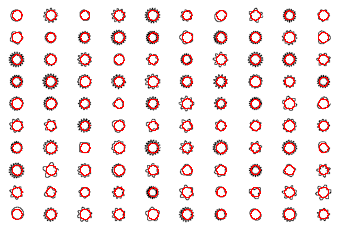

In [17]:
model = model.eval()
DonutDataset.displayCanvas('test6layerConstantWidth.png',test_dataset, model = model)


In [18]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 1.7876880168914795


In [19]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [20]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [21]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.3177413940429688
epoch 1 	Training loss 1.5775927305221558
epoch 2 	Training loss 1.3338333368301392
epoch 3 	Training loss 1.511012077331543
epoch 4 	Training loss 1.53157377243042
epoch 5 	Training loss 1.450045108795166
epoch 6 	Training loss 1.3786555528640747
epoch 7 	Training loss 1.260758876800537
epoch 8 	Training loss 1.3959776163101196
epoch 9 	Training loss 1.2642297744750977
epoch 10 	Training loss 1.1747251749038696
epoch 11 	Training loss 1.2703965902328491
epoch 12 	Training loss 1.570987343788147
epoch 13 	Training loss 1.4236687421798706
epoch 14 	Training loss 1.2034046649932861
epoch 15 	Training loss 1.1049553155899048
epoch 16 	Training loss 1.3315296173095703
epoch 17 	Training loss 1.2425484657287598
epoch 18 	Training loss 1.218231201171875
epoch 19 	Training loss 1.3368571996688843
epoch 20 	Training loss 1.3435230255126953
epoch 21 	Training loss 1.2920215129852295
epoch 22 	Training loss 1.1974995136260986
epoch 23 	Training loss 1.47

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [23]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 1.1259169578552246
epoch 1 	Training loss 1.0993572473526
epoch 2 	Training loss 1.0842058658599854
epoch 3 	Training loss 1.0910632610321045
epoch 4 	Training loss 1.0810108184814453
epoch 5 	Training loss 1.16643488407135
epoch 6 	Training loss 1.1618891954421997
epoch 7 	Training loss 1.0748658180236816
epoch 8 	Training loss 1.3029553890228271
epoch 9 	Training loss 1.147594690322876
epoch 10 	Training loss 1.0809673070907593
epoch 11 	Training loss 1.2617820501327515
epoch 12 	Training loss 1.112382411956787
epoch 13 	Training loss 1.2091010808944702
epoch 14 	Training loss 1.1079111099243164
epoch 15 	Training loss 1.0343972444534302
epoch 16 	Training loss 1.2146145105361938
epoch 17 	Training loss 1.1393790245056152
epoch 18 	Training loss 1.1505448818206787
epoch 19 	Training loss 1.0647443532943726
epoch 20 	Training loss 1.3410340547561646
epoch 21 	Training loss 1.2554594278335571
epoch 22 	Training loss 1.102341890335083
epoch 23 	Training loss 1.038

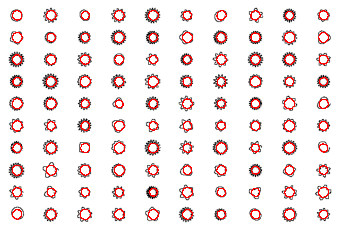

In [24]:
model = model.eval()
DonutDataset.displayCanvas('test6layer10xConstantWidth.png',test_dataset, model = model)


In [25]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 2.0726425647735596


The 6 layer gets slow with 10x units. accuracy also gets worse.  


In [26]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [27]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [28]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.50325608253479
epoch 1 	Training loss 1.673175573348999
epoch 2 	Training loss 1.5608630180358887
epoch 3 	Training loss 1.3993093967437744
epoch 4 	Training loss 1.4153497219085693
epoch 5 	Training loss 1.4239414930343628
epoch 6 	Training loss 1.227885127067566
epoch 7 	Training loss 1.2054715156555176
epoch 8 	Training loss 1.1426504850387573
epoch 9 	Training loss 1.0898269414901733
epoch 10 	Training loss 1.0263621807098389
epoch 11 	Training loss 0.8841832876205444
epoch 12 	Training loss 0.9273070693016052
epoch 13 	Training loss 0.7405288219451904
epoch 14 	Training loss 0.7676555514335632
epoch 15 	Training loss 0.621181309223175
epoch 16 	Training loss 0.6031638383865356
epoch 17 	Training loss 0.5593088865280151
epoch 18 	Training loss 0.5986932516098022
epoch 19 	Training loss 0.5407276153564453
epoch 20 	Training loss 0.5306751728057861
epoch 21 	Training loss 0.5186699032783508
epoch 22 	Training loss 0.4559897184371948
epoch 23 	Training loss 0.

In [29]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [30]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 0.32043683528900146
epoch 1 	Training loss 0.30327504873275757
epoch 2 	Training loss 0.32149749994277954
epoch 3 	Training loss 0.2485027313232422
epoch 4 	Training loss 0.2775212526321411
epoch 5 	Training loss 0.2898780107498169
epoch 6 	Training loss 0.26000675559043884
epoch 7 	Training loss 0.2761913537979126
epoch 8 	Training loss 0.2787357568740845
epoch 9 	Training loss 0.24772034585475922
epoch 10 	Training loss 0.2531031370162964
epoch 11 	Training loss 0.2500710189342499
epoch 12 	Training loss 0.24679043889045715
epoch 13 	Training loss 0.24613700807094574
epoch 14 	Training loss 0.2538178563117981
epoch 15 	Training loss 0.2381574809551239
epoch 16 	Training loss 0.24124890565872192
epoch 17 	Training loss 0.24357149004936218
epoch 18 	Training loss 0.2557799816131592
epoch 19 	Training loss 0.2582847774028778
epoch 20 	Training loss 0.2414647340774536
epoch 21 	Training loss 0.2326543927192688
epoch 22 	Training loss 0.24382317066192627
epoch 23 	T

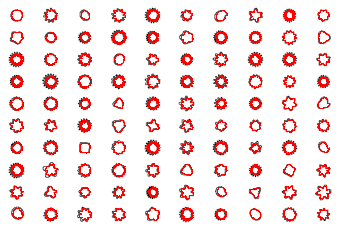

In [31]:
model = model.eval()
DonutDataset.displayCanvas('test3layer10xConstantWidth.png',test_dataset, model = model)


In [32]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 0.39177417755126953


In [33]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 100*self.input_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):

      #x = x.squeeze()
      if x.shape[0]!= mini_batch:
        assert x.shape[0] == 32 and x.shape[1] == 32
        x = x.unsqueeze(0)
      x = torch.flatten(x,start_dim=1)
      
      #assert x.shape == (mini_batch,self.hidden_dim)
      out = self.net(x)
      out = out.reshape(x.shape[0],1000,2)
      return 32.0*out


In [34]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [35]:
loss = None
#model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
  

  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.395268440246582
epoch 1 	Training loss 1.1960355043411255
epoch 2 	Training loss 0.8456118106842041
epoch 3 	Training loss 0.6670902967453003
epoch 4 	Training loss 0.5683469772338867
epoch 5 	Training loss 0.45566511154174805
epoch 6 	Training loss 0.30485615134239197
epoch 7 	Training loss 0.24628274142742157
epoch 8 	Training loss 0.21373780071735382
epoch 9 	Training loss 0.2010052353143692
epoch 10 	Training loss 0.1787949949502945
epoch 11 	Training loss 0.17304621636867523
epoch 12 	Training loss 0.1560828536748886
epoch 13 	Training loss 0.1523178219795227
epoch 14 	Training loss 0.1451234221458435
epoch 15 	Training loss 0.1395755410194397
epoch 16 	Training loss 0.13354088366031647
epoch 17 	Training loss 0.12188050150871277
epoch 18 	Training loss 0.12336140871047974
epoch 19 	Training loss 0.11418367177248001
epoch 20 	Training loss 0.11022262275218964
epoch 21 	Training loss 0.1063397154211998
epoch 22 	Training loss 0.10658838599920273
epoch 23 	T

In [36]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [37]:
loss = None
#model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 0.06833382695913315
epoch 1 	Training loss 0.0666835606098175
epoch 2 	Training loss 0.06417176872491837
epoch 3 	Training loss 0.0646880492568016
epoch 4 	Training loss 0.06292058527469635
epoch 5 	Training loss 0.06007786840200424
epoch 6 	Training loss 0.06187107786536217
epoch 7 	Training loss 0.06051251292228699
epoch 8 	Training loss 0.05768056586384773
epoch 9 	Training loss 0.05648474022746086
epoch 10 	Training loss 0.061918772757053375
epoch 11 	Training loss 0.05719894915819168
epoch 12 	Training loss 0.05823637172579765
epoch 13 	Training loss 0.05566369742155075
epoch 14 	Training loss 0.056548718363046646
epoch 15 	Training loss 0.05896162614226341
epoch 16 	Training loss 0.05612592399120331
epoch 17 	Training loss 0.053975909948349
epoch 18 	Training loss 0.053978901356458664
epoch 19 	Training loss 0.053366389125585556
epoch 20 	Training loss 0.05180950462818146
epoch 21 	Training loss 0.05253712832927704
epoch 22 	Training loss 0.0509142093360424

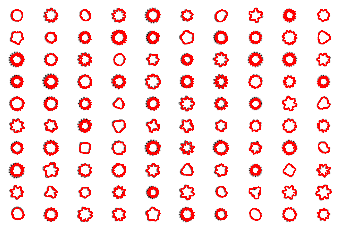

In [38]:
DonutDataset.displayCanvas('test2layer100x.png',test_dataset, model = model)


In [39]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 0.21251022815704346


In [40]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [41]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [42]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 28.81912612915039
epoch 1 	Training loss 17.594804763793945
epoch 2 	Training loss 11.470170021057129
epoch 3 	Training loss 7.601457595825195
epoch 4 	Training loss 7.033586502075195
epoch 5 	Training loss 5.928812026977539
epoch 6 	Training loss 5.157736301422119
epoch 7 	Training loss 4.47379207611084
epoch 8 	Training loss 4.712771892547607
epoch 9 	Training loss 4.921469688415527
epoch 10 	Training loss 4.4927568435668945
epoch 11 	Training loss 5.164187431335449
epoch 12 	Training loss 4.752413272857666
epoch 13 	Training loss 4.999860763549805
epoch 14 	Training loss 3.811434268951416
epoch 15 	Training loss 4.1274261474609375
epoch 16 	Training loss 4.712552070617676
epoch 17 	Training loss 3.856779098510742
epoch 18 	Training loss 4.016477108001709
epoch 19 	Training loss 4.508003234863281
epoch 20 	Training loss 4.249686241149902
epoch 21 	Training loss 4.1381707191467285
epoch 22 	Training loss 3.997901439666748
epoch 23 	Training loss 4.07225036621093

In [43]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [44]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.9082746505737305
epoch 1 	Training loss 4.2840495109558105
epoch 2 	Training loss 3.9400408267974854
epoch 3 	Training loss 3.5686447620391846
epoch 4 	Training loss 2.873793601989746
epoch 5 	Training loss 3.644235610961914
epoch 6 	Training loss 3.196549654006958
epoch 7 	Training loss 3.237055778503418
epoch 8 	Training loss 3.448845863342285
epoch 9 	Training loss 3.4348161220550537
epoch 10 	Training loss 3.2465505599975586
epoch 11 	Training loss 3.041877508163452
epoch 12 	Training loss 3.420417547225952
epoch 13 	Training loss 3.16498064994812
epoch 14 	Training loss 3.060641288757324
epoch 15 	Training loss 3.7945282459259033
epoch 16 	Training loss 3.3008742332458496
epoch 17 	Training loss 3.5628445148468018
epoch 18 	Training loss 3.049729824066162
epoch 19 	Training loss 2.9394800662994385
epoch 20 	Training loss 3.219986915588379
epoch 21 	Training loss 3.2850019931793213
epoch 22 	Training loss 3.3091750144958496
epoch 23 	Training loss 3.1881117

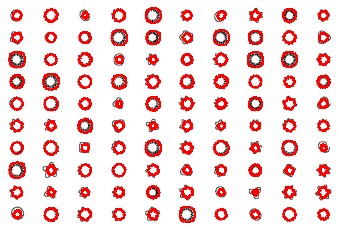

In [45]:
model = model.eval()
DonutDataset.displayCanvas('test1layer.png',test_dataset, model = model)


In [46]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 3.5052969455718994


max min x tensor(30.3238) tensor(1.6751)
max min y tensor(28.6029) tensor(3.1037)


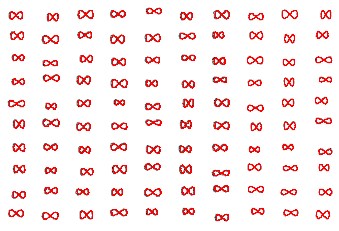

In [49]:
#add donut here
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def f8_matrix(length = 10):
    
    canvas = torch.zeros((length,side, side))
    x = torch.zeros((length,numpoints))
    y = torch.zeros((length,numpoints))
        
    ###

    for i in range(length):
      t = torch.linspace(0,2*3.14159,numpoints)
      x[i,:] = t.cos()
      y[i,:] = t.sin()*t.cos()

      WIDTH = 14
      randMultx = np.random.uniform(8.0,WIDTH-.1)
      randMulty = np.random.uniform(8.0,WIDTH-.1)

      maxaddx = WIDTH-randMultx
      maxaddy = 3.0+WIDTH-randMulty
      
      assert maxaddx >0
      assert maxaddy >0

      randAddx = np.random.uniform(-maxaddx,maxaddx)
      randAddy = np.random.uniform(-maxaddy,maxaddy)

      randMultSinx = np.random.uniform(.25,.5)
      randMultSiny = np.random.uniform(.25,.5)
      randMultFreqSinx = np.random.uniform(10.0,20.0)
      randMultFreqSiny = np.random.uniform(10.0,20.0)
      #randAddSinx = np.random.uniform(0.0,1.0)
      #randAddSiny = np.random.uniform(0.0,1.0)
      xsin = randMultSiny*((t*randMultFreqSinx).sin())#+randAddSinx
      ysin = randMultSiny*((t*randMultFreqSiny).sin())#+randAddSiny
      #print('maxxsin',torch.max(xsin))
      x[i,:] = (x[i,:]*randMultx)+16+randAddx+xsin
      y[i,:] = (y[i,:]*randMulty)+16+randAddy+ysin
  
    assert torch.max(x).item() < 32
    assert torch.min(x).item() > 0
    assert torch.max(y).item() < 32
    assert torch.min(y).item() > 0
    
    print("max min x",torch.max(x),torch.min(x))
    print("max min y",torch.max(y),torch.min(y))
    ###
    
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all_f8( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            pred = model(sample)
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            
            s = [.01 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            plt.plot(X.cpu(),Y.cpu(),',-',c='red', ms=.1, lw=0.1) 

    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class Figure8Dataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = f8_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all_f8(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)
        
dataset = Figure8Dataset(length = 100)

Figure8Dataset.displayCanvas('donut.png',dataset, model = None)

In [64]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
test_dataset = Figure8Dataset(length=64)
loader_test = data.DataLoader(
    test_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=test_dataset),
    num_workers=4)


max min x tensor(30.3091) tensor(1.7672)
max min y tensor(28.1932) tensor(3.5385)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [54]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
dataset = None
mini_batch = 64
train_dataset = Figure8Dataset(length=64*20)
loader_train = data.DataLoader(
    train_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=train_dataset),
    num_workers=4)


max min x tensor(30.4383) tensor(1.5275)
max min y tensor(29.3496) tensor(2.9127)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [55]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 100*self.input_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):

      #x = x.squeeze()
      if x.shape[0]!= mini_batch:
        assert x.shape[0] == 32 and x.shape[1] == 32
        x = x.unsqueeze(0)
      x = torch.flatten(x,start_dim=1)
      
      #assert x.shape == (mini_batch,self.hidden_dim)
      out = self.net(x)
      out = out.reshape(x.shape[0],1000,2)
      return 32.0*out


In [56]:
model = MLP().cuda()


In [57]:
optimizer = torch.optim.Adam(model.parameters(),lr = .0001, betas = (0.9,0.999))

In [58]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.628714084625244
epoch 1 	Training loss 1.038686990737915
epoch 2 	Training loss 0.4739589989185333
epoch 3 	Training loss 0.31989142298698425
epoch 4 	Training loss 0.2502354383468628
epoch 5 	Training loss 0.22466032207012177
epoch 6 	Training loss 0.1879282295703888
epoch 7 	Training loss 0.1829470992088318
epoch 8 	Training loss 0.16248932480812073
epoch 9 	Training loss 0.16052891314029694
epoch 10 	Training loss 0.14086607098579407
epoch 11 	Training loss 0.13754144310951233
epoch 12 	Training loss 0.13528114557266235
epoch 13 	Training loss 0.12501050531864166
epoch 14 	Training loss 0.12135732173919678
epoch 15 	Training loss 0.12232127040624619
epoch 16 	Training loss 0.11329488456249237
epoch 17 	Training loss 0.11072513461112976
epoch 18 	Training loss 0.10963425040245056
epoch 19 	Training loss 0.1044316440820694
epoch 20 	Training loss 0.10304673761129379
epoch 21 	Training loss 0.09434691071510315
epoch 22 	Training loss 0.09391949325799942
epoch 2

In [59]:
optimizer = torch.optim.Adam(model.parameters(),lr = .00001, betas = (0.9,0.999))

In [60]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 0.06702347099781036
epoch 1 	Training loss 0.05887053906917572
epoch 2 	Training loss 0.05762111768126488
epoch 3 	Training loss 0.0569140762090683
epoch 4 	Training loss 0.05824863910675049
epoch 5 	Training loss 0.05413198471069336
epoch 6 	Training loss 0.054606981575489044
epoch 7 	Training loss 0.05298895761370659
epoch 8 	Training loss 0.051734454929828644
epoch 9 	Training loss 0.051280274987220764
epoch 10 	Training loss 0.05129499360918999
epoch 11 	Training loss 0.051823798567056656
epoch 12 	Training loss 0.050840120762586594
epoch 13 	Training loss 0.04869033023715019
epoch 14 	Training loss 0.04933761805295944
epoch 15 	Training loss 0.049864090979099274
epoch 16 	Training loss 0.04915556311607361
epoch 17 	Training loss 0.046262308955192566
epoch 18 	Training loss 0.04717012122273445
epoch 19 	Training loss 0.046353790909051895
epoch 20 	Training loss 0.046393983066082
epoch 21 	Training loss 0.04541775956749916
epoch 22 	Training loss 0.04515691474

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1000, 2])


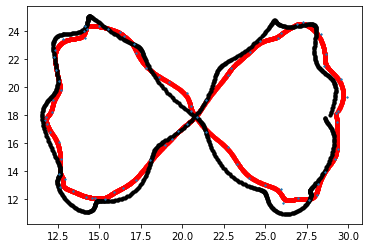

In [66]:
from scipy.interpolate import splprep, splev
from numpy import arange, cos, linspace, pi, sin, random

#display fits on validation set
xgt = None
ygt = None

out = None


for xin,yin in loader_test:
  out = model(xin.cuda())
  out = out.reshape(yin[:,:,:2].shape)
  xgt = yin[:,:,0]
  ygt = yin[:,:,1]
out = out[2,:,:]
xpred = out[:,0].detach()
ypred = out[:,1].detach()
print(out.shape)
xgt=xgt[2,:]
ygt=ygt[2,:]

t=np.linspace(0,1,1000)
z = t

# spline parameters
s=75 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([xpred.cpu().numpy(),ypred.cpu().numpy(),z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,4000),tck)

ascatter = plt.scatter(xnew,ynew,s=10,c='red')
ascatter = plt.scatter(xgt.cpu().numpy(),ygt.cpu().numpy(),s=10,c='black')
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)
plt.savefig('figure8fit.png', dpi=600)

In [67]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


validation loss 	 0.3192458152770996
